# A Machine Learning Approach to Visual Perception of Corridor Trails for Mobile Robots

@Author: Artur Leinweber <br>
@E-Mail: arturleinweber@live.de <br>
@University: Westphalian University of Gelsenkirchen <br>

### Imports
tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality.
Importing tf.keras makes TensorFlow easier to use without sacrificing flexibility and performance.


In [1]:
%matplotlib inline  
import tensorflow as tf
from tensorflow.keras import layers, regularizers, utils, preprocessing, optimizers, backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import time
import os
import cv2
import sys

print("Tensorflow Version: " + tf.VERSION)
print("Keras Version: " + tf.keras.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)

/home/gas/venv_laptop_jupyter/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gas/venv_laptop_jupyter/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gas/venv_laptop_jupyter/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gas/venv_laptop_jupyter/lib/python3.6/site-packages/ten

Tensorflow Version: 1.14.0
Keras Version: 2.2.4-tf


Progressbar function

In [2]:
def update_progress(progress, custom=""):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = custom + "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text, end="\r")

### Sequential model
In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model.

In [3]:
# Layer 1
Conv2DLayer1 = layers.Conv2D(input_shape = (101,101,1),
                             filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005)) 

ActivationLayer1 = layers.Activation("tanh")

NormalizationLayer1 = layers.BatchNormalization()

PoolingLayer1 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")

# Layer 2
Conv2DLayer2 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer2 = layers.Activation("tanh")

NormalizationLayer2 = layers.BatchNormalization()

PoolingLayer2 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 3
Conv2DLayer3 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer3 = layers.Activation("tanh")

NormalizationLayer3 = layers.BatchNormalization()

PoolingLayer3 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 4
Conv2DLayer4 = layers.Conv2D(filters = 32,
                             kernel_size = (3,3),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer4 = layers.Activation("tanh")

NormalizationLayer4 = layers.BatchNormalization()

PoolingLayer4 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Fully Connected Layer
FlattenLayer5 = layers.Flatten()
#DenseLayer5 = layers.Dense(200, kernel_initializer = "glorot_uniform")
DenseLayer5 = layers.Dense(130, kernel_initializer = "glorot_uniform")
ActivationLayer5 = layers.Activation("tanh")
NormalizationLayer5 = layers.BatchNormalization()

# Softmax Classifier
DenseLayer6 = layers.Dense(3)
ActivationLayer6 = layers.Activation("softmax")

model_architecture = [
         Conv2DLayer1,
         ActivationLayer1,
         NormalizationLayer1,
         PoolingLayer1,
         
         Conv2DLayer2,
         ActivationLayer2,
         NormalizationLayer2,
         PoolingLayer2,
         
#         Conv2DLayer3,
#         ActivationLayer3,
#         NormalizationLayer3,
#         PoolingLayer3,
         
#         Conv2DLayer4,
#         ActivationLayer4,
#         NormalizationLayer4,
#         PoolingLayer4,
         
         FlattenLayer5,
         DenseLayer5,
         ActivationLayer5,
         NormalizationLayer5,
         
         DenseLayer6,
         ActivationLayer6]

model = tf.keras.Sequential(model_architecture)

### Prints a summary representation of the model

In [4]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        544       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        16416     
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        1

### Plot a graph of the model and save it to a file

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


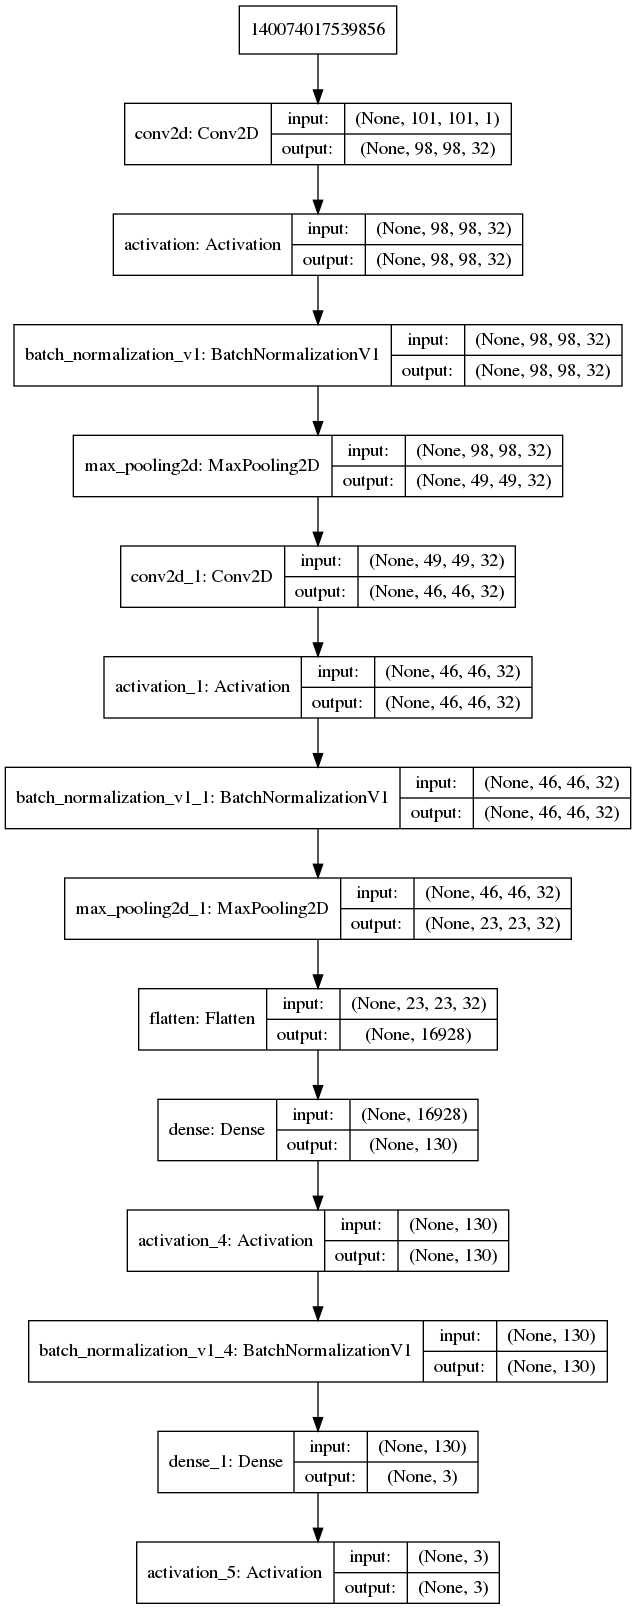

In [5]:
utils.plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'plots/model.png')
Image(retina = True, filename = 'plots/model.png')

## Set up Training

Arguments for Training, that we need to set are:
* The path to the input dataset.
* The number of epochs to train for.
* Path for Our loss/accuracy plot, that will be output to disk
* etc.

In [6]:
MODEL_NAME = "corridor"
DATASET_PATH = os.getcwd() + "/dataset/corridor"
VALIDATION_PATH = DATASET_PATH + "/validation"
TRAIN_PATH = DATASET_PATH + "/train"
TRAIN_EVAL_PLOT_PATH = os.getcwd() + "/plots"

DATASET_PATH_MODIFIED =  os.getcwd() + "/dataset/corridor_m"
VALIDATION_PATH_MODIFIED = DATASET_PATH_MODIFIED + "/validation"
TRAIN_PATH_MODIFIED = DATASET_PATH_MODIFIED + "/train"

NUMBER_OF_EPOCHS = 300
BATCH_SIZE = 64
INIT_LEARNING_RATE = 1e-4
DECAY_LEARNING_RATE = 1e-4 / NUMBER_OF_EPOCHS

Here we can see the dataset structure:

+ dataset / corridor
    
    - validation
        - left (X Files)
        - forward (X Files)
        - right (X Files)
    - train
        - left (X Files)
        - forward (X Files)
        - right (X Files)

Initialize the set of labels from dataset we are going to train our network on.

In [7]:
LABELS = list(["left","forward","right"])

Genrate a list of image pathes for our training

In [8]:
train_image_paths = list(paths.list_images(TRAIN_PATH))
validation_image_paths = list(paths.list_images(VALIDATION_PATH))

print("Size of the train-dataset: " + str(len(train_image_paths)))
print("Size of the validation-dataset: " + str(len(validation_image_paths)))

Size of the train-dataset: 30914
Size of the validation-dataset: 15305


Load default dataset and create a new one with data augemtation. Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images.

In [ ]:
i = 0.0
for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)[212:906, 468:1399]
    image = cv2.resize(image, (101, 101))
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + label + '/' + filename, image)

In [9]:
train_image_paths = list(paths.list_images(TRAIN_PATH_MODIFIED))

In [ ]:
i = 0.0
for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    if label == 'left':
        label = 'right'
    elif label == 'right':
        label = 'left'
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue
 
    image = cv2.flip(cv2.imread(imagePath), cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + label + '/f' + filename, image)

In [10]:
train_image_paths = list(paths.list_images(TRAIN_PATH_MODIFIED))
print("Size of the train-dataset: " + str(len(train_image_paths)))

Size of the train-dataset: 61828


In [11]:
train_images = []
validation_images = []

train_labels = []
validation_labels = []
i = 0.0

for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
 
    train_images.append(image)
    train_labels.append(label)

In [ ]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)[212:906, 468:1399]
    image = cv2.resize(image, (101, 101))
    cv2.imwrite(VALIDATION_PATH_MODIFIED + '/' + label + '/' + filename, image)

In [12]:
validation_image_paths = list(paths.list_images(VALIDATION_PATH_MODIFIED))

In [ ]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    if label == 'left':
        label = 'right'
    elif label == 'right':
        label = 'left'
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue

    image = cv2.flip(cv2.imread(imagePath), cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(VALIDATION_PATH_MODIFIED + '/' + label + '/f' + filename, image)

In [13]:
validation_image_paths = list(paths.list_images(VALIDATION_PATH_MODIFIED))
print("Size of the validation-dataset: " + str(len(validation_image_paths)))

Size of the validation-dataset: 30610


In [14]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
 
    validation_images.append(image)
    validation_labels.append(label)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
print("Size of the train-dataset: " + str(len(train_images)))
print("Size of the validation-dataset: " + str(len(validation_images)))

Size of the train-dataset: 61828
Size of the validation-dataset: 30610


Convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range (0, 1)

In [16]:
train_images = np.expand_dims(np.array(train_images, dtype = "float") / 255.0, axis=3)
validation_images = np.expand_dims(np.array(validation_images, dtype = "float") / 255.0, axis=3)
print(train_images.shape)

(61828, 101, 101, 1)


Creating one-hot encoding vectors on the labels (for each image!)

In [17]:
left_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))
forward_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))
right_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))

train_hot_encoding_vectors = []
validation_hot_encoding_vectors = []

left_hot_encoding[:] =    [1, 0, 0]
forward_hot_encoding[:] = [0, 1, 0]
right_hot_encoding[:] =   [0, 0, 1]

for label in train_labels:
    if(label == "left"):
        train_hot_encoding_vectors.append(left_hot_encoding)
    elif(label == "forward"):
        train_hot_encoding_vectors.append(forward_hot_encoding)
    elif(label == "right"):
        train_hot_encoding_vectors.append(right_hot_encoding)
        
for label in validation_labels:
    if(label == "left"):
        validation_hot_encoding_vectors.append(left_hot_encoding)
    elif(label == "forward"):
        validation_hot_encoding_vectors.append(forward_hot_encoding)
    elif(label == "right"):
        validation_hot_encoding_vectors.append(right_hot_encoding)

train_hot_encoding_vectors = np.asarray(train_hot_encoding_vectors)
validation_hot_encoding_vectors = np.asarray(validation_hot_encoding_vectors)

In [18]:
for i in range(len(LABELS)):
    index = train_labels.index(LABELS[i])
    print(str(LABELS[i]) + ":" + str(train_hot_encoding_vectors[index]))

#for i in range(len(LABELS)):
#    index = validation_labels.index(LABELS[i])
#    print(str(LABELS[i]) + ":" + str(validation_hot_encoding_vectors[index]))

left:[1 0 0]
forward:[0 1 0]
right:[0 0 1]


Construct the training image generator for data augmentation

In [19]:
dataAugmentation = preprocessing.image.ImageDataGenerator(rotation_range = 15,
                                                          zoom_range = 0.10,
                                                          width_shift_range = 0.1,
                                                          height_shift_range = 0.1,
                                                          shear_range = 0.0,
                                                          horizontal_flip = False,
                                                          vertical_flip = False,
                                                          fill_mode="nearest")

Initialize Adam Optimizer

In [20]:
#sgdOptimizer = optimizers.SGD(lr=INIT_LEARNING_RATE, momentum=0.75, decay=DECAY_LEARNING_RATE, nesterov=True)
adamOptimizer = optimizers.Adam(lr = INIT_LEARNING_RATE, decay = DECAY_LEARNING_RATE)

After the model is constructed, configure its learning process by calling the compile method

In [21]:
model.compile(loss = "categorical_crossentropy", optimizer = adamOptimizer, metrics = ["accuracy"])

Save the entire model (HDF5 file) after every epoch (period).

In [22]:
checkpoint_saver = tf.keras.callbacks.ModelCheckpoint('./checkpoints/'+ MODEL_NAME +'_weights{epoch:08d}.h5',
                                save_weights_only=False,
                                period=1,
                                verbose=1,
                                save_best_only=False,
                                mode='auto')

## Training

Returns whether TensorFlow can access a Nvidia GPU with CUDA

In [23]:
tf.test.is_gpu_available(cuda_only = True)

True

Training the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).
The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

In [24]:
start_time = time.time()

trainHistory = model.fit_generator(dataAugmentation.flow(train_images, train_hot_encoding_vectors, batch_size = BATCH_SIZE),
                                   validation_data = (validation_images, validation_hot_encoding_vectors),
                                   steps_per_epoch = len(train_images) // BATCH_SIZE,
                                   epochs = 100,
                                   verbose = 2,
                                   callbacks = [checkpoint_saver])

end_time = time.time()

Epoch 1/100

Epoch 00001: saving model to ./checkpoints/corridor_weights00000001.h5
966/966 - 54s - loss: 0.5461 - acc: 0.7767 - val_loss: 0.5535 - val_acc: 0.7682
Epoch 2/100

Epoch 00002: saving model to ./checkpoints/corridor_weights00000002.h5
966/966 - 59s - loss: 0.3206 - acc: 0.8816 - val_loss: 0.5211 - val_acc: 0.8035
Epoch 3/100

Epoch 00003: saving model to ./checkpoints/corridor_weights00000003.h5
966/966 - 60s - loss: 0.2466 - acc: 0.9122 - val_loss: 0.3230 - val_acc: 0.8882
Epoch 4/100

Epoch 00004: saving model to ./checkpoints/corridor_weights00000004.h5
966/966 - 60s - loss: 0.2112 - acc: 0.9268 - val_loss: 0.2565 - val_acc: 0.9097
Epoch 5/100

Epoch 00005: saving model to ./checkpoints/corridor_weights00000005.h5
966/966 - 63s - loss: 0.1890 - acc: 0.9331 - val_loss: 0.3436 - val_acc: 0.8881
Epoch 6/100

Epoch 00006: saving model to ./checkpoints/corridor_weights00000006.h5
966/966 - 66s - loss: 0.1795 - acc: 0.9380 - val_loss: 0.2608 - val_acc: 0.9026
Epoch 7/100

Epo

KeyboardInterrupt: 

In [25]:
end_time = time.time()
needed_time_sec = end_time - start_time
hours = int(needed_time_sec/60/60)
minutes = int(needed_time_sec/60%60)
secondes = int(needed_time_sec%60)
print("Total training time: " + str(hours) + "[h] " + str(minutes) + "[min] " + str(secondes) + "[sec]")

Total training time: 0[h] 43[min] 38[sec]


A History.history attribute saves a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

## Evaluation
To evaluate our model, we’ll use the validation data and print a classification_report

In [26]:
predictions = model.predict(validation_images, batch_size = BATCH_SIZE)
print(classification_report(validation_hot_encoding_vectors.argmax(axis = 1),
                            predictions.argmax(axis = 1),
                            target_names = np.asarray(LABELS)))

              precision    recall  f1-score   support

        left       0.83      0.85      0.84     10253
     forward       0.94      0.89      0.92     10104
       right       0.83      0.84      0.84     10253

    accuracy                           0.86     30610
   macro avg       0.87      0.86      0.86     30610
weighted avg       0.87      0.86      0.86     30610



Plot our accuracy/loss training history and save it to disk

In [28]:
N = NUMBER_OF_EPOCHS
H = trainHistory
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label = "val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.savefig(TRAIN_EVAL_PLOT_PATH + "/"+ MODEL_NAME +"_Loss_Accuracy.png")

ymax = max(H.history["val_acc"])
xpos = H.history["val_acc"].index(ymax)
print("Best val. Accuracy " + str(H.history["val_acc"][xpos]) + " at Epoch " + str(xpos+1))
plt.plot([xpos],[H.history["val_acc"][xpos]],"ro",markersize=12)
plt.show()

NameError: name 'trainHistory' is not defined

### Sources
- https://www.tensorflow.org/guide/keras
- http://rpg.ifi.uzh.ch/docs/RAL16_Giusti.pdf
- https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
- https://keras.io/models/sequential/